<a href="https://colab.research.google.com/github/je-santos/MPLBM-UT/blob/master/examples/create_2D_training_data_4NN/VelNet_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vel-net

## by Javier and Bernard

### (some cool banner goes here)
--------------
## Table of contents
- XXX. Libraries and examples
- Data visualization
- Data analysis
- Simplier methods: Linear regression
- Intro to NN: parabolic profile
- Intro to convnets

In [1]:
#@title Importing libraries and downloading data
#%%capture

!pip install git+https://github.com/je-santos/livelossplot

import os
import sys
import random

# Importing the numerical and viz libs
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

# Importing utilities libs 
import glob
from PIL import Image

# Importing the ML libs
import sklearn
import tensorflow as tf
from tensorflow import keras


from livelossplot import PlotLossesKeras
from livelossplot.plot_losses  import MatplotlibPlot
    
import warnings
warnings.simplefilter("ignore")

try:
  os.mkdir('numpys')
except:
  pass 


!git clone https://github.com/je-santos/PoreFlow-Net.git
!mv PoreFlow-Net/ilustrations/numpys.zip numpys/numpys.zip
os.chdir('numpys')


from zipfile import ZipFile
with ZipFile('numpys.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()
os.chdir('..')




  Cloning https://github.com/je-santos/livelossplot to c:\users\jae3287\appdata\local\temp\pip-req-build-a64iw0zk
  Created wheel for livelossplot: filename=livelossplot-0.5.0-py3-none-any.whl size=20505 sha256=485a18ede752e8c171a559c7aa966436fc1d402f28b6e6728aec2bc47d6d7e99
  Stored in directory: C:\Users\jae3287\AppData\Local\Temp\pip-ephem-wheel-cache-4uo1qcw4\wheels\d1\85\7f\91c563589b9efae46dcb114d7983ea917ecaa1f37efb85023c
Successfully built livelossplot


fatal: destination path 'PoreFlow-Net' already exists and is not an empty directory.
'mv' is not recognized as an internal or external command,
operable program or batch file.


The shape of X is (866, 128, 256) and the shape of y is (866, 128, 256): (Number of examples, x and y)


## Loading the data

In [140]:
# load the file
X = np.load('numpys/X.npy')
y = np.load('numpys/y.npy').astype(np.float32)

k   = np.mean(y, axis=(1,2))*100000 #normalize the permeability

# data cleaning (remove non-percolating samples)
def drop_samples(x,ind):
    return x[ind]

indices = np.where(k>0.01) # drop the samples where the permeability is lower than 0.01 [D]
X,y,k   = [drop_samples(array,indices) for array in [X,y,k]]


phi = 1-np.mean(X, axis=(1,2)) # calculating the porosity


print(f'The shape of X is {X.shape} and the shape of y is {y.shape}')
print('                  (Number of examples, x and y)')
print()
print(f'The average porosity is {np.mean(phi)*100:4.2f}% and the average permeability is {np.mean(k):0.2} [Darcy]')

The shape of X is (792, 128, 256) and the shape of y is (792, 128, 256)
                  (Number of examples, x and y)

The average porosity is 44.32% and the average permeability is 1.3 [Darcy]


## Data visualization

Text(0.5, 0, 'log10(permeability) [Darcy]')

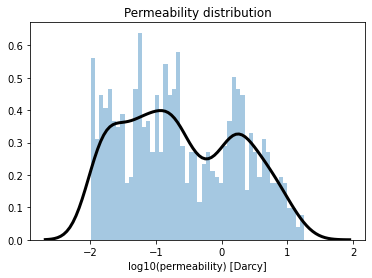

In [142]:
sns.distplot(np.log10(k),bins=50, kde_kws={"color": "k", "lw": 3})
plt.title('Permeability distribution')
plt.xlabel('log10(permeability) [Darcy]')

Text(0.5, 0, 'Porosity')

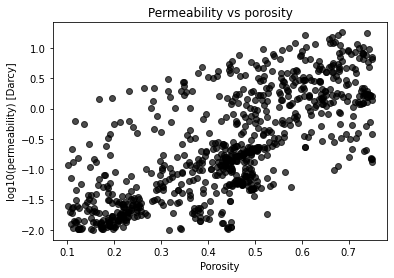

In [135]:
plt.scatter(phi,np.log10(k),c='k',alpha=0.7)
plt.title('Permeability vs porosity')
plt.ylabel('log10(permeability) [Darcy]')
plt.xlabel('Porosity')

IntSlider(value=400, description='Im number', max=792)

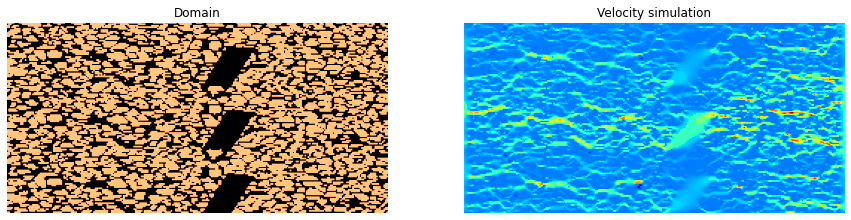

In [171]:
im_num = 0

w = widgets.IntSlider()
w.value= 0
w.min =  0
w.max =  X.shape[0]
w.description='Im number'
display(w)

def plot_im(*args):
    clear_output(wait=True)
    display(w)
    
    #plt.figure(dpi=300)
    plt.subplot(1,2,1)
    plt.imshow(X[w.value], cmap='copper', clim=(0,.75))
    plt.axis('off')
    plt.title('Domain')
    plt.subplot(1,2,2)
    plt.imshow(y[w.value], cmap='jet')
    plt.axis('off')
    plt.title('Velocity simulation')
    
    fig = plt.gcf() 
    fig.set_size_inches(15,6)
    
plot_im()
w.observe(plot_im,'value')

## What's a neuron?

A neuron performs a mathematical operation where the input data ($x$) is multiplied by a $\textit{weight}$ ($w$) followed by the addition of a $\textit{bias term}$ ($b$). These are called $\textit{trainable parameters}$.

$y=x*w+b$

Additionally, this ouput  can passed through a non-linear activation function.

$y_{_{NL}} = f(y)$

Some examples of non-linearities commonly used in NN are the following:

- $ReLU(y)     = max(0, y)$

- $sigmoid(y) = 1 / (1 + exp(-y))$

Each function has distint properties that can benefit certain applications.

IntRangeSlider(value=(-10, 10), description='Input range:', max=10, min=-10)

FloatSlider(value=-1.5, description='Weight value:', max=5.0, min=-5.0)

FloatSlider(value=0.1, description='Bias value:', max=5.0, min=-5.0)

RadioButtons(description='Activation:', index=2, options=('linear', 'sigmoid', 'ReLU'), value='ReLU')

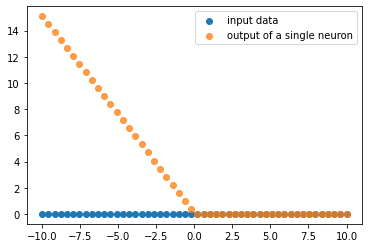

In [30]:
#@title A single neuron
import ipywidgets as widgets
from IPython.display import display

xi = widgets.IntRangeSlider()
xi.min = -10
xi.max =  10
xi.value= [-2, 2]
xi.description='Input range:'
display(xi)


w = widgets.FloatSlider()
w.value= 1
w.min = -5
w.max =  5
w.description='Weight value:'
display(w)

b = widgets.FloatSlider()
b.value= 0
b.min = -5
b.max =  5
b.description='Bias value:'
display(b)

act = widgets.RadioButtons()
act.options=['linear','sigmoid','ReLU']
act.description = 'Activation:'
display(act)

    
def plot_w(*args):
#def plot_w(xi=xi,w=w,b=b,act=act):
    print(f'Hi my first value is {xi.value[0]}')
    x_t = np.linspace(xi.value[0],xi.value[1])
    y_t = x_t*w.value+b.value
    if act.value=='sigmoid':
        y_t = 1 / (1 + np.exp(-y_t))
    if act.value=='ReLU':
        y_t = np.maximum(y_t,0)

    #plt.figure(1)
    #plt.close()
    clear_output(wait=True)
    display(xi,w,b,act)
    plt.scatter(x_t, np.zeros_like(x_t))
    plt.scatter(x_t, y_t,alpha=0.75)
    plt.legend(['input data','output of a single neuron'])
    plt.show()

plot_w()
    
xi.observe(plot_w,'value')
w.observe(plot_w,'value')
b.observe(plot_w,'value')
act.observe(plot_w,'value')


## How does a neuron learn?

The the values of the neuron's weight ($w$) and  bias ($b$) are adjusted (or trained) based on the training data provided. These parameters are trained by minimizing the function:

$Loss = loss\_f(y\_pred, y\_true)$

Intuitively, this process can be seen as minimizing the error (or mismatch) of the training data with the ouput of the neural network. Common loss functions ($\textit{$loss\_f$}$) for inference include mean squared error and mean absolute error, and binary crossentrophy for segmentation.

In [7]:
# performing splits
split      = 0.8
num_train  = int(split*X.shape[0])
print(f'Total samples in the data set: {X.shape[0]}, we will use {num_train} for training')

Total samples in the data set: 866, we will use 692 for training


## What happens when we use multiple neurons? 

https://playground.tensorflow.org


In [8]:
model_name = 'test_class'
# we create a number with the model name (unique)
rnd_seed = np.sum( [ord(letter) for letter in model_name] )*123123
# we use this num as the rnd seed for numpy
np.random.seed( rnd_seed )
IDs = np.arange( X.shape[0] ) 
np.random.shuffle( IDs )
X_train, y_train = X[IDs[:num_train]], y[IDs[:num_train]]
X_test,  y_test  = X[IDs[num_train:]], y[IDs[num_train:]]


In [9]:
y_test.shape

(174, 128, 256)

In [10]:
174+692

866

In [177]:
from IPython.display import Image
from IPython.core.display import HTML 
display(Image(url= "https://github.com/je-santos/MPLBM-UT/blob/master/illustrations/playground.png"))

%%html
![image here](https://github.com/je-santos/MPLBM-UT/blob/master/illustrations/playground.png)

<img src="https://github.com/je-santos/MPLBM-UT/blob/master/illustrations/playground.png" style="height:50px"> 

In [11]:
linear_model = keras.Sequential([keras.layers.Dense(1,input_shape=[1])])
linear_model.compile(loss='mse',optimizer=keras.optimizers.Adam())
linear_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [12]:
non_linear_model = keras.Sequential()
non_linear_model.add(keras.layers.Dense(10,activation='selu',input_shape=[1]))
non_linear_model.add(keras.layers.Dense(1,activation='selu'))
non_linear_model.compile(loss='mse',optimizer=keras.optimizers.Adam())
non_linear_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                20        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


In [ ]:
linear_model.fit(x=X_mean, y=y_mean, callbacks=PlotLossesKeras(), epochs=40, validation_split=0.2)

In [ ]:
non_linear_model.fit(x=X_mean, y=y_mean, callbacks=PlotLossesKeras(), epochs=200, validation_split=0.2)

In [ ]:
non_linear_model.fit(x=X_mean, y=y_mean, callbacks=PlotLossesKeras(), epochs=400, validation_split=0.2)

In [2]:
def vel_profile(x):
    return 1-x**2

In [3]:
x = np.linspace(-1,1,100)

In [4]:
y = vel_profile(x)

Text(0, 0.5, 'Velocity')

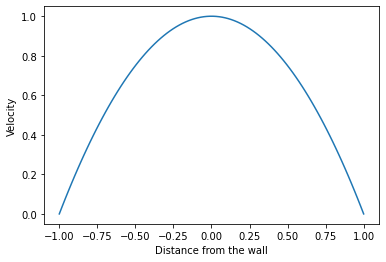

In [5]:
plt.plot(x,y)
plt.xlabel('Distance from the wall')
plt.ylabel('Velocity')

In [6]:
x_train = x[:10]

In [ ]:
keras.backend.set_value(linear_model.optimizer.learning_rate, 0.01)
# add relative error

In [ ]:
linear_model.fit(x=x_train, y=y[:10], callbacks=PlotLossesKeras(), epochs=1000, validation_split=0)

In [ ]:
y_pred = linear_model.predict(x=x[10:])

In [ ]:
plt.plot(x,y)
plt.plot(x_train, y[:10],'o', label='training data')
plt.plot(x[10:], y_pred)

plt.xlabel('Distance from the wall')
plt.ylabel('Velocity')

In [7]:
IDs = np.arange( x.shape[0] ) 
np.random.shuffle( IDs )
x_train = x[IDs[:10]]
y_train = y[IDs[:10]]

In [ ]:
x_train

In [ ]:
linear_model.fit(x=x_train, y=y_train, callbacks=PlotLossesKeras(), epochs=200, validation_split=0)

In [ ]:
y_pred = linear_model.predict(x=x[10:])

In [ ]:
plt.plot(x,y)
plt.plot(x_train, y_train,'o')
plt.plot(x[10:], y_pred)

plt.xlabel('Distance from the wall')
plt.ylabel('Velocity')

In [ ]:
keras.backend.set_value(non_linear_model.optimizer.learning_rate, 0.01)
non_linear_model.fit(x=x_train, y=y_train, callbacks=PlotLossesKeras(), epochs=400, validation_split=0)

In [ ]:
y_pred_NL = non_linear_model.predict(x=x)

In [ ]:
plt.plot(x,y)
plt.plot(x_train, y_train,'o')
plt.plot(x[10:], y_pred)
plt.plot(x, y_pred_NL)


plt.xlabel('Distance from the wall')
plt.ylabel('Velocity')

In [8]:
non_linear_model = keras.Sequential()
non_linear_model.add(keras.layers.Dense(1,use_bias=False,activation='linear',input_shape=[1]))
non_linear_model.add(keras.layers.Dense(1,use_bias=True,activation='linear'))
non_linear_model.compile(loss='mse',optimizer=keras.optimizers.Adam())
non_linear_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 1         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [9]:
keras.backend.set_value(non_linear_model.optimizer.learning_rate, 0.01)
non_linear_model.fit(x=x_train, y=y_train, callbacks=PlotLossesKeras(), epochs=400, validation_split=0)

Epoch 1/400


InternalError:  Blas GEMV launch failed:  m=1, n=10
	 [[node sequential/dense/MatMul (defined at <ipython-input-9-87fa196f5274>:2) ]] [Op:__inference_train_function_508]

Function call stack:
train_function


In [ ]:
#maybe 3D here???

In [ ]:
def profile_3D(x,y):
    return 1-(x**2 + y**2)

In [ ]:
x1 = np.linspace(-1,1,10)
x2 = np.linspace(-1,1,10)
y = profile_3D(x1,x2)

In [ ]:
x1_test = (np.random.rand(1000)-0.5)*2
x2_test = (np.random.rand(1000)-0.5)*2
y_real = profile_3D(x1_test, x2_test)
input_test = np.stack([x1_test,x2_test]).T

In [ ]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(input_test[:,0], input_test[:,1], y_real, alpha=0.1)
#ax.scatter(input_test[:,0], input_test[:,1], y_test, alpha=0.5)
#ax.scatter(x1,x2,y, s=500)
#plt.legend(['real function', 'NN prediction','training data'])
plt.title("We don't do extremely well with these training set")

In [1]:
!pip freeze > requirements.txt